In [1]:
#1. Import necessary modules
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import joblib

# 2. Loading the Data:

In [2]:
# Define the paths to the ZIP files
#train_zip = 'GUIDE_Train.csv.zip'
#test_zip = 'GUIDE_Test.csv.zip'

# Unzipping the training file
#with zipfile.ZipFile(train_zip, 'r') as zip_ref:
#    zip_ref.extractall()  # Extracts files to the current directory

# Unzipping the testing file
#with zipfile.ZipFile(test_zip, 'r') as zip_ref:
#    zip_ref.extractall()  # Extracts files to the current directory

In [3]:
# Reading the unzipped CSV files into DataFrames
#train_data = pd.read_csv('/content/GUIDE_Train.csv')
#test_data = pd.read_csv('/content/GUIDE_Test.csv')

# 3. Understanding the Data:

# Train Data

In [4]:
import gc

def optimize_memory(df):
    for col in df.select_dtypes(include=['int64', 'float64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='integer')
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].astype('category')
    return df

train_dataset = "GUIDE_Train.csv"
chunks = []

try:
    for chunk in pd.read_csv(train_dataset, chunksize=100000, low_memory=False, encoding='utf-8'):
        try:
            chunk = optimize_memory(chunk)
            chunks.append(chunk)
        except pd.errors.ParserError:
            pass  # Skip this chunk if there's a parsing error
except FileNotFoundError:
    print("File not found. Please check the file path.")
except pd.errors.EmptyDataError:
    print("File is empty.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

# Concatenate all chunks if there's any valid data
if chunks:
    train_data = pd.concat(chunks, ignore_index=True)
    # Clean up memory
    del chunks
    gc.collect()
    print("Data concatenated successfully.")
else:
    print("No valid data to concatenate.")


Data concatenated successfully.


In [5]:
train_data.head()

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,...,ResourceType,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City
0,180388628218,0,612,123247,2024-06-04T06:05:15.000Z,7,6,InitialAccess,NaN,TruePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,31,6,3
1,455266534868,88,326,210035,2024-06-14T03:01:25.000Z,58,43,Exfiltration,NaN,FalsePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630
2,1056561957389,809,58352,712507,2024-06-13T04:52:55.000Z,423,298,InitialAccess,T1189,FalsePositive,...,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630
3,1279900258736,92,32992,774301,2024-06-10T16:39:36.000Z,2,2,CommandAndControl,NaN,BenignPositive,...,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630
4,214748368522,148,4359,188041,2024-06-15T01:08:07.000Z,9,74,Execution,NaN,TruePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630


In [6]:
train_data.columns


Index(['Id', 'OrgId', 'IncidentId', 'AlertId', 'Timestamp', 'DetectorId',
       'AlertTitle', 'Category', 'MitreTechniques', 'IncidentGrade',
       'ActionGrouped', 'ActionGranular', 'EntityType', 'EvidenceRole',
       'DeviceId', 'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn',
       'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId',
       'EmailClusterId', 'RegistryKey', 'RegistryValueName',
       'RegistryValueData', 'ApplicationId', 'ApplicationName',
       'OAuthApplicationId', 'ThreatFamily', 'FileName', 'FolderPath',
       'ResourceIdName', 'ResourceType', 'Roles', 'OSFamily', 'OSVersion',
       'AntispamDirection', 'SuspicionLevel', 'LastVerdict', 'CountryCode',
       'State', 'City'],
      dtype='object')

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9516837 entries, 0 to 9516836
Data columns (total 45 columns):
 #   Column              Dtype   
---  ------              -----   
 0   Id                  int64   
 1   OrgId               int16   
 2   IncidentId          int32   
 3   AlertId             int32   
 4   Timestamp           object  
 5   DetectorId          int16   
 6   AlertTitle          int32   
 7   Category            object  
 8   MitreTechniques     object  
 9   IncidentGrade       category
 10  ActionGrouped       object  
 11  ActionGranular      object  
 12  EntityType          object  
 13  EvidenceRole        category
 14  DeviceId            int32   
 15  Sha256              int32   
 16  IpAddress           int32   
 17  Url                 int32   
 18  AccountSid          int32   
 19  AccountUpn          int32   
 20  AccountObjectId     int32   
 21  AccountName         int32   
 22  DeviceName          int32   
 23  NetworkMessageId    int32   
 24

In [8]:
train_data.describe()

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,DeviceId,Sha256,IpAddress,Url,...,ApplicationName,OAuthApplicationId,FileName,FolderPath,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City
count,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,...,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06
mean,8.425494e+11,1.815800e+02,7.066349e+04,4.065188e+05,1.106724e+02,2.947315e+03,9.566476e+04,1.287191e+05,2.857506e+05,1.503317e+05,...,3.342790e+03,8.807955e+02,2.622621e+05,1.076172e+05,3.583477e+03,4.898537e+00,6.465558e+01,2.236742e+02,1.351488e+03,9.936183e+03
std,4.962499e+11,3.867784e+02,1.208369e+05,4.592827e+05,4.351038e+02,1.146150e+04,1.635288e+04,3.399208e+04,1.412240e+05,3.750795e+04,...,5.103381e+02,1.291083e+01,8.152956e+04,3.220835e+04,9.020262e+01,7.035099e-01,9.314929e+00,6.279729e+01,3.509808e+02,2.606812e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.123169e+11,1.000000e+01,5.040000e+02,2.324200e+04,2.000000e+00,2.000000e+00,9.879900e+04,1.382680e+05,3.606060e+05,1.603960e+05,...,3.421000e+03,8.810000e+02,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04
50%,8.418136e+11,4.500000e+01,1.033600e+04,2.166520e+05,9.000000e+00,1.100000e+01,9.879900e+04,1.382680e+05,3.606060e+05,1.603960e+05,...,3.421000e+03,8.810000e+02,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04
75%,1.271310e+12,1.710000e+02,8.432900e+04,6.715770e+05,4.500000e+01,1.800000e+02,9.879900e+04,1.382680e+05,3.606060e+05,1.603960e+05,...,3.421000e+03,8.810000e+02,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04
max,1.709397e+12,6.147000e+03,5.997060e+05,1.721456e+06,9.522000e+03,1.131740e+05,9.879900e+04,1.382680e+05,3.606060e+05,1.603960e+05,...,3.421000e+03,8.810000e+02,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04


# Handling Missing Data

In [9]:
train_data.isnull().sum()

Id                          0
OrgId                       0
IncidentId                  0
AlertId                     0
Timestamp                   0
DetectorId                  0
AlertTitle                  0
Category                    0
MitreTechniques       5468386
IncidentGrade           51340
ActionGrouped         9460773
ActionGranular        9460773
EntityType                  0
EvidenceRole                0
DeviceId                    0
Sha256                      0
IpAddress                   0
Url                         0
AccountSid                  0
AccountUpn                  0
AccountObjectId             0
AccountName                 0
DeviceName                  0
NetworkMessageId            0
EmailClusterId        9420025
RegistryKey                 0
RegistryValueName           0
RegistryValueData           0
ApplicationId               0
ApplicationName             0
OAuthApplicationId          0
ThreatFamily          9441956
FileName                    0
FolderPath

In [10]:
# Droping Columns with More Than 50% Missing Values:
train_data.drop(columns=['MitreTechniques', 'ActionGrouped', 'ActionGranular', 'EmailClusterId', 
                       'ThreatFamily', 'ResourceType', 'Roles', 'AntispamDirection', 'SuspicionLevel', 'LastVerdict'], 
               axis=1, inplace=True)

In [11]:
train_data.isnull().sum()

Id                        0
OrgId                     0
IncidentId                0
AlertId                   0
Timestamp                 0
DetectorId                0
AlertTitle                0
Category                  0
IncidentGrade         51340
EntityType                0
EvidenceRole              0
DeviceId                  0
Sha256                    0
IpAddress                 0
Url                       0
AccountSid                0
AccountUpn                0
AccountObjectId           0
AccountName               0
DeviceName                0
NetworkMessageId          0
RegistryKey               0
RegistryValueName         0
RegistryValueData         0
ApplicationId             0
ApplicationName           0
OAuthApplicationId        0
FileName                  0
FolderPath                0
ResourceIdName            0
OSFamily                  0
OSVersion                 0
CountryCode               0
State                     0
City                      0
dtype: int64

In [12]:
# Fill NaN values in 'IncidentGrade' with the mode
mode_value = train_data['IncidentGrade'].mode()[0]  # Get the mode of the column
train_data['IncidentGrade'].fillna(mode_value, inplace=True)

In [13]:
train_data.isnull().sum()

Id                    0
OrgId                 0
IncidentId            0
AlertId               0
Timestamp             0
DetectorId            0
AlertTitle            0
Category              0
IncidentGrade         0
EntityType            0
EvidenceRole          0
DeviceId              0
Sha256                0
IpAddress             0
Url                   0
AccountSid            0
AccountUpn            0
AccountObjectId       0
AccountName           0
DeviceName            0
NetworkMessageId      0
RegistryKey           0
RegistryValueName     0
RegistryValueData     0
ApplicationId         0
ApplicationName       0
OAuthApplicationId    0
FileName              0
FolderPath            0
ResourceIdName        0
OSFamily              0
OSVersion             0
CountryCode           0
State                 0
City                  0
dtype: int64

In [14]:
train_data.duplicated().sum()

546298

In [15]:
# Droping duplicate rows from the dataset
train_data = train_data.drop_duplicates()

print(f"Number of rows after removing duplicates: {train_data.shape[0]}")

Number of rows after removing duplicates: 8970539


In [16]:
# Target variable distribution
print("Target variable distribution:")
train_data['IncidentGrade'].value_counts()

Target variable distribution:


IncidentGrade
BenignPositive    3875534
TruePositive      3140126
FalsePositive     1954879
Name: count, dtype: int64

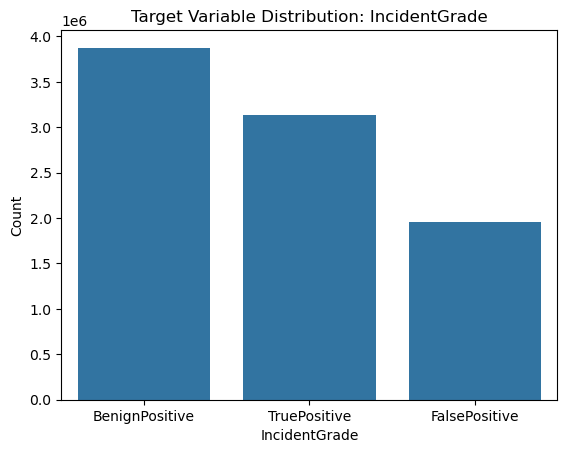

In [17]:
sns.countplot(data=train_data, x='IncidentGrade', order=train_data['IncidentGrade'].value_counts().index)
plt.title('Target Variable Distribution: IncidentGrade')
plt.xlabel('IncidentGrade')
plt.ylabel('Count')
plt.show()

# Feature Exploration and Engineering

In [18]:
train_data['Timestamp'] = pd.to_datetime(train_data['Timestamp'])
train_data['Year'] = train_data['Timestamp'].dt.year
train_data['Month'] = train_data['Timestamp'].dt.month
train_data['Day'] = train_data['Timestamp'].dt.day
train_data['Hour'] = train_data['Timestamp'].dt.hour

train_data.drop(columns='Timestamp',inplace=True)

In [19]:
train_data.columns

Index(['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'AlertTitle',
       'Category', 'IncidentGrade', 'EntityType', 'EvidenceRole', 'DeviceId',
       'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn',
       'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId',
       'RegistryKey', 'RegistryValueName', 'RegistryValueData',
       'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 'FileName',
       'FolderPath', 'ResourceIdName', 'OSFamily', 'OSVersion', 'CountryCode',
       'State', 'City', 'Year', 'Month', 'Day', 'Hour'],
      dtype='object')

# 4. Exploratory Data Analysis (EDA) - Visualizing Distributions

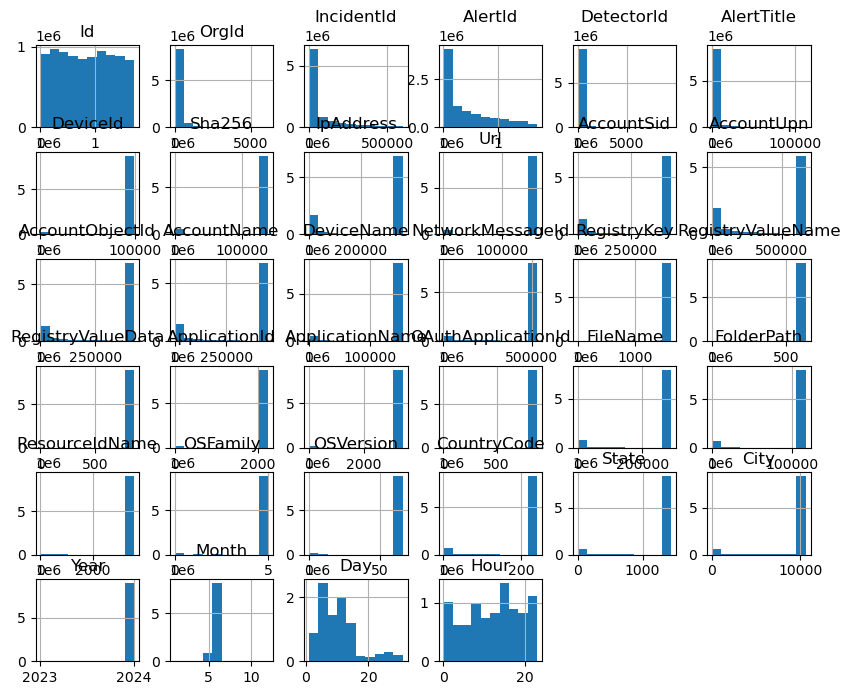

In [20]:
train_data.hist(figsize=(10,8))
plt.show()

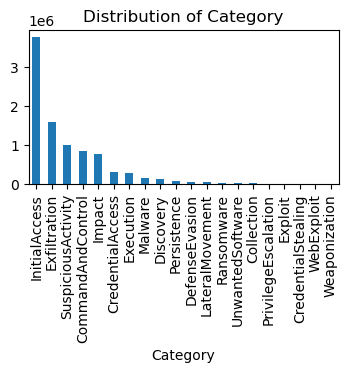

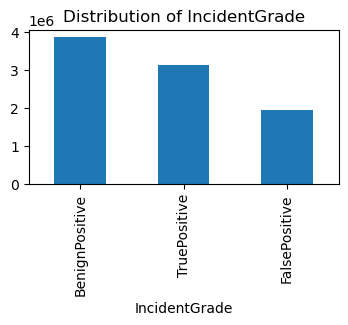

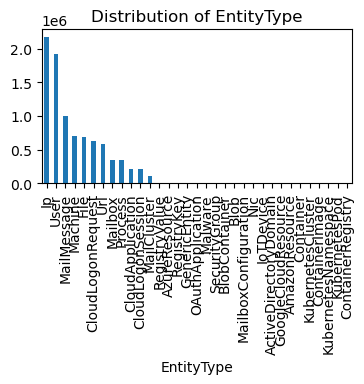

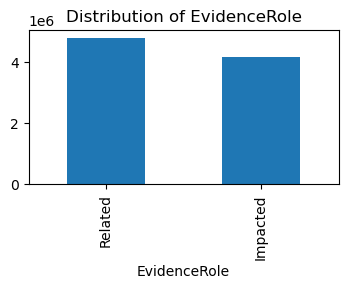

In [21]:
# Bar plot for categorical data
# List of categorical columns in DataFrame
categorical_columns = train_data.select_dtypes(include=['object','category'])

for col in categorical_columns:
    plt.figure(figsize=(4, 2))
    train_data[col].value_counts().plot(kind='bar')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.show()

# Visualizing the Data to Identify Outliers

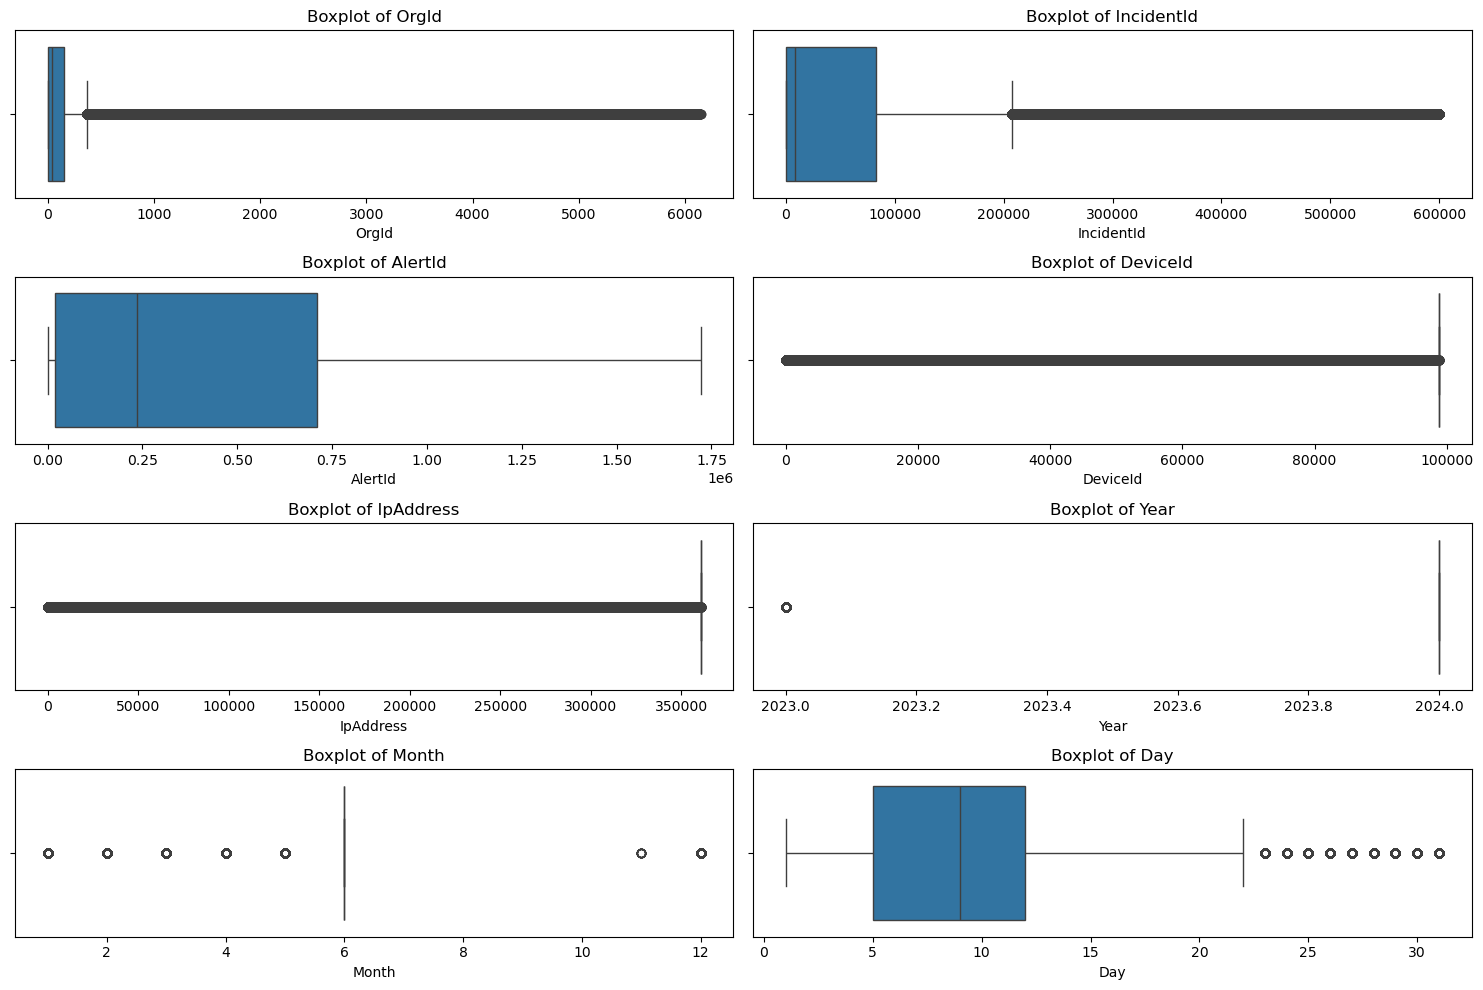

In [22]:
# Ploting box plots for numerical columns
numeric_cols = ['OrgId', 'IncidentId', 'AlertId', 'DeviceId', 'IpAddress', 'Year', 'Month', 'Day']
plt.figure(figsize=(15, 10))
num_plots = len(numeric_cols)
rows = (num_plots + 1) // 2

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(rows, 2, i)
    sns.boxplot(x=train_data[col])
    plt.title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

# Correlation Analysis

In [23]:
train_data1 = train_data.copy()

In [24]:
# List of Numerical columns in DataFrame
numeric_columns = train_data.select_dtypes(include=['int8','int16', 'int32', 'int64', 'float64'])
# cheking num columns
numeric_columns.columns

Index(['Id', 'OrgId', 'DetectorId', 'RegistryKey', 'RegistryValueName',
       'RegistryValueData', 'ApplicationId', 'ApplicationName',
       'OAuthApplicationId', 'ResourceIdName', 'OSFamily', 'OSVersion',
       'CountryCode', 'State', 'City', 'Year', 'Month', 'Day', 'Hour'],
      dtype='object')

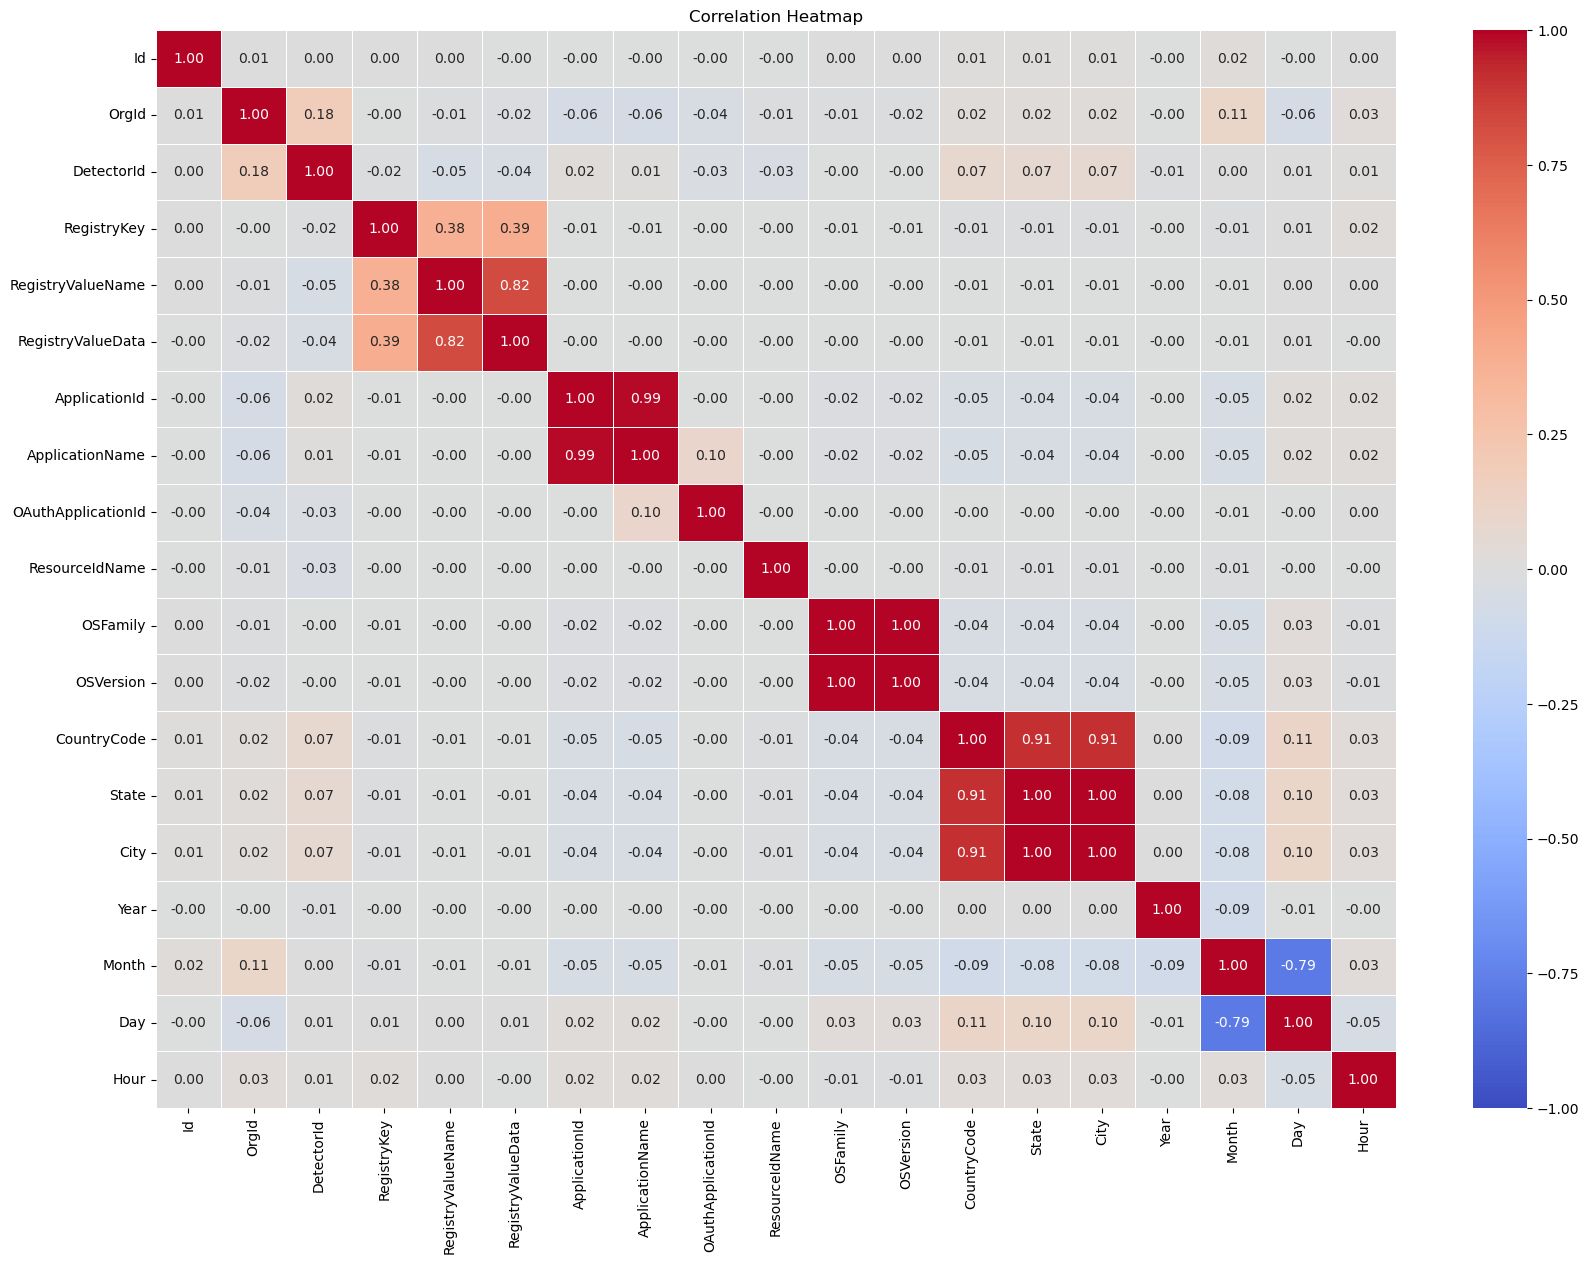

In [25]:
# heatmap visualization
plt.figure(figsize=(20, 14))
sns.heatmap(numeric_columns.corr(), annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

# Feature Importance via Random Forest

In [26]:
# ID columns that don't help in model training
id_columns = ['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'DeviceId', 'Sha256', 
              'IpAddress', 'Url', 'AccountSid', 'AccountUpn', 'AccountObjectId',
              'NetworkMessageId', 'RegistryKey', 'RegistryValueName', 
              'RegistryValueData', 'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 
              'FileName', 'FolderPath', 'ResourceIdName']

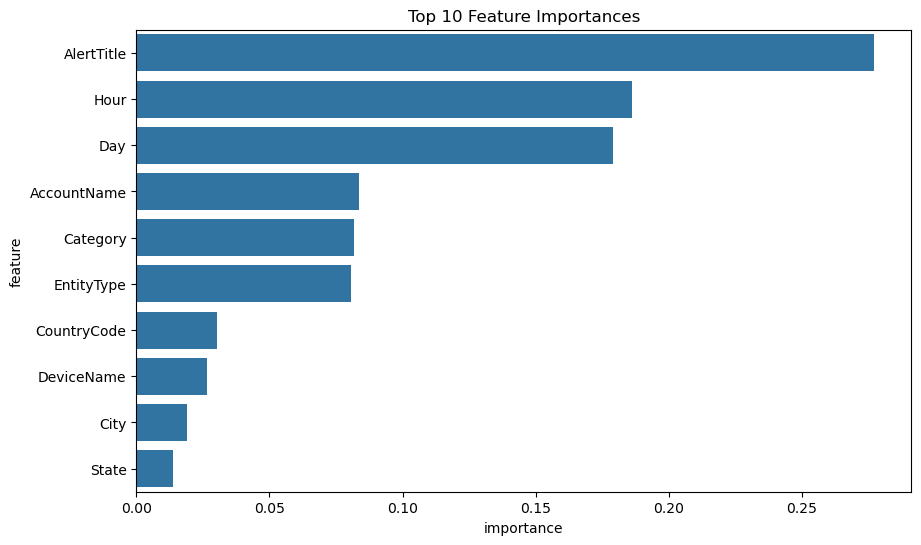

In [27]:
train_sample = train_data.sample(frac=0.001, random_state=42)
X = train_sample.drop(id_columns + ['IncidentGrade'], axis=1, errors='ignore')
y = train_sample['IncidentGrade']

non_numeric_cols = X.select_dtypes(exclude=['number']).columns
le = LabelEncoder()
for col in non_numeric_cols:
    X[col] = le.fit_transform(X[col].astype(str))

# Random Forest model
rf = RandomForestClassifier()
rf.fit(X, y)
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_})
feature_importances = feature_importances.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances.head(10))
plt.title('Top 10 Feature Importances')
plt.show()

In [28]:
#total df imp
imp_features= [
    'Alert Title', 'Hour', 'Day', 'AccountName', 'Category', 'EntityType', 'DeviceName', 'CountryCode', 'State', 'City']

In [29]:
print(train_data.columns)
train_data.shape

Index(['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'AlertTitle',
       'Category', 'IncidentGrade', 'EntityType', 'EvidenceRole', 'DeviceId',
       'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn',
       'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId',
       'RegistryKey', 'RegistryValueName', 'RegistryValueData',
       'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 'FileName',
       'FolderPath', 'ResourceIdName', 'OSFamily', 'OSVersion', 'CountryCode',
       'State', 'City', 'Year', 'Month', 'Day', 'Hour'],
      dtype='object')


(8970539, 38)

In [30]:
train_data.nunique()

Id                     730778
OrgId                    5769
IncidentId             466151
AlertId               1265644
DetectorId               8428
AlertTitle              86149
Category                   20
IncidentGrade               3
EntityType                 33
EvidenceRole                2
DeviceId                75826
Sha256                 106416
IpAddress              285957
Url                    123252
AccountSid             358401
AccountUpn             530183
AccountObjectId        343516
AccountName            368250
DeviceName             114541
NetworkMessageId       375196
RegistryKey              1341
RegistryValueName         525
RegistryValueData         699
ApplicationId            1728
ApplicationName          2681
OAuthApplicationId        703
FileName               222085
FolderPath              87832
ResourceIdName           2309
OSFamily                    6
OSVersion                  58
CountryCode               236
State                    1368
City      

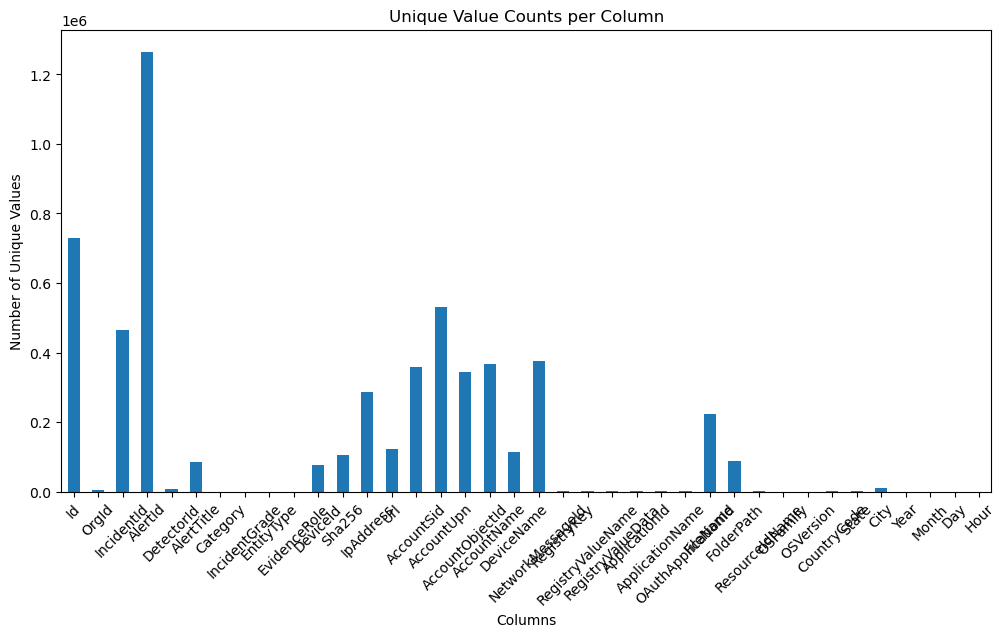

In [31]:
unique_counts = train_data.nunique()
unique_counts.plot(kind='bar', figsize=(12, 6))
plt.title('Unique Value Counts per Column')
plt.xlabel('Columns')
plt.ylabel('Number of Unique Values')
plt.xticks(rotation=45)
plt.show()

In [32]:
train_data['AlertTitle'].value_counts()

AlertTitle
0         1320736
2          597423
1          480010
4          412029
3          412025
           ...   
112232          1
110362          1
110346          1
111797          1
110883          1
Name: count, Length: 86149, dtype: int64

In [33]:
train_data['Url'].value_counts()

Url
160396    8381106
0            8195
1            6607
2            5264
6            4238
           ...   
149473          1
97186           1
80819           1
79769           1
113074          1
Name: count, Length: 123252, dtype: int64

In [34]:
train_data['DeviceName'].value_counts().head(20)

DeviceName
153085    8274527
0            4376
1            3944
5            2153
4            2152
6            1879
13           1727
7            1631
10           1545
9            1519
8            1512
11           1284
12           1251
16           1187
15           1095
14           1094
22           1021
28            932
20            920
17            813
Name: count, dtype: int64

In [35]:
train_data['City'].value_counts()

City
10630    8342804
0         103145
1          22075
2          19195
3          15787
          ...   
5464           1
7403           1
6960           1
6598           1
10554          1
Name: count, Length: 9342, dtype: int64

In [36]:
train_data['OrgId'].value_counts()

OrgId
0       844839
2       236415
1       210086
3       189731
5       173301
         ...  
6074         1
6091         1
6114         1
6144         1
6116         1
Name: count, Length: 5769, dtype: int64

In [37]:
train_data['AccountSid'].value_counts().head(20)

AccountSid
441377    6857115
0           14469
1            8978
2            6017
3            5262
4            3770
5            3596
7            3144
8            2832
11           2552
6            2353
9            2349
12           2129
15           1993
14           1986
17           1930
18           1924
16           1878
19           1859
21           1847
Name: count, dtype: int64

In [38]:
train_data['AccountSid'].value_counts()

AccountSid
441377    6857115
0           14469
1            8978
2            6017
3            5262
           ...   
299216          1
273613          1
393047          1
353186          1
349553          1
Name: count, Length: 358401, dtype: int64

In [39]:
train_data['IncidentGrade'].value_counts()

IncidentGrade
BenignPositive    3875534
TruePositive      3140126
FalsePositive     1954879
Name: count, dtype: int64

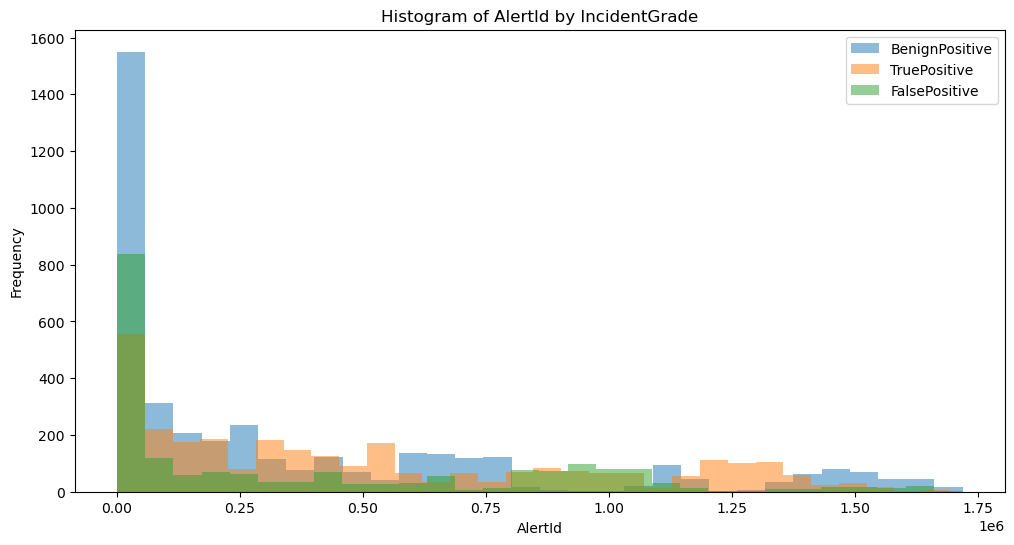

In [40]:
train_sample = train_data1.sample(frac=0.001, random_state=42)

plt.figure(figsize=(12, 6))
for grade in train_sample['IncidentGrade'].unique():
    subset = train_sample[train_sample['IncidentGrade'] == grade]
    plt.hist(subset['AlertId'], bins=30, alpha=0.5, label=grade)

plt.xlabel('AlertId')
plt.ylabel('Frequency')
plt.title('Histogram of AlertId by IncidentGrade')
plt.legend()
plt.show()

In [41]:
# These features have minimal importance or are unlikely to impact your classification outcome
columns_to_drop = [
    'Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'DetectorId','Sha256', 'IpAddress', 
    'AccountSid', 'AccountUpn', 'AccountObjectId', 'DeviceId', 'NetworkMessageId',
    'RegistryKey', 'RegistryValueName', 'RegistryValueData', 'ApplicationId', 'ApplicationName',
    'OAuthApplicationId', 'FileName', 'FolderPath', 'ResourceIdName', 'OSVersion'
]
train_data.drop(columns=columns_to_drop, inplace=True)

In [42]:
print(train_data.columns)
train_data.shape

Index(['AlertTitle', 'Category', 'IncidentGrade', 'EntityType', 'EvidenceRole',
       'Url', 'AccountName', 'DeviceName', 'OSFamily', 'CountryCode', 'State',
       'City', 'Year', 'Month', 'Day', 'Hour'],
      dtype='object')


(8970539, 16)

# Handling Outliers

In [43]:
def handle_outliers(df, iqr_multiplier=3.0):
    numeric_features = df.select_dtypes(include=['int8','int16', 'int32', 'int64', 'float64'])
    for col in numeric_features.columns:
        # IQR method
        Q1 = numeric_features[col].quantile(0.25)
        Q3 = numeric_features[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - iqr_multiplier * IQR
        upper_bound = Q3 + iqr_multiplier * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
        
        # Quantile Capping
        q_low = df[col].quantile(0.01)
        q_high = df[col].quantile(0.99)
        df[col] = df[col].clip(lower=q_low, upper=q_high)
        
    return df

In [44]:
train_data.head()

,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,Url,AccountName,DeviceName,OSFamily,CountryCode,State,City,Year,Month,Day,Hour
0,6,InitialAccess,TruePositive,Ip,Related,160396,453297,153085,5,31,6,3,2024,6,4,6
1,43,Exfiltration,FalsePositive,User,Impacted,160396,24887,153085,5,242,1445,10630,2024,6,14,3
2,298,InitialAccess,FalsePositive,Url,Related,68652,453297,153085,5,242,1445,10630,2024,6,13,4
3,2,CommandAndControl,BenignPositive,Url,Related,13,453297,153085,5,242,1445,10630,2024,6,10,16
4,74,Execution,TruePositive,User,Impacted,160396,479,153085,5,242,1445,10630,2024,6,15,1


In [45]:
print(train_data.columns)
train_data.shape

Index(['AlertTitle', 'Category', 'IncidentGrade', 'EntityType', 'EvidenceRole',
       'Url', 'AccountName', 'DeviceName', 'OSFamily', 'CountryCode', 'State',
       'City', 'Year', 'Month', 'Day', 'Hour'],
      dtype='object')


(8970539, 16)

# Encoding Categorical Variables

# Label Encoding for Ordinal Variables \ One-hot encoding for nominal columns

In [46]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8970539 entries, 0 to 9516836
Data columns (total 16 columns):
 #   Column         Dtype   
---  ------         -----   
 0   AlertTitle     int32   
 1   Category       object  
 2   IncidentGrade  category
 3   EntityType     object  
 4   EvidenceRole   category
 5   Url            int32   
 6   AccountName    int32   
 7   DeviceName     int32   
 8   OSFamily       int8    
 9   CountryCode    int16   
 10  State          int16   
 11  City           int16   
 12  Year           int32   
 13  Month          int32   
 14  Day            int32   
 15  Hour           int32   
dtypes: category(2), int16(3), int32(8), int8(1), object(2)
memory usage: 556.1+ MB


In [47]:
categorical_columns = ['AlertTitle', 'Category', 'EntityType', 'EvidenceRole',
       'Url', 'AccountName', 'DeviceName', 'OSFamily', 'CountryCode', 'State', 'City', 'Year',
       'Month', 'Day', 'Hour']

In [48]:
# List of columns to process
columns_to_group = ['AlertTitle', 'Url', 'AccountName', 'DeviceName', 'CountryCode', 'State', 'City']

# Looping through each column and grouping the less frequent values into "Others"
for column in columns_to_group:
    category_counts = train_data[column].value_counts()
    top_categories = category_counts.nlargest(8).index
    train_data[column] = train_data[column].where(train_data[column].isin(top_categories), 'Others')

# Now verifing the changes
train_data


,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,Url,AccountName,DeviceName,OSFamily,CountryCode,State,City,Year,Month,Day,Hour
0,6,InitialAccess,TruePositive,Ip,Related,160396,453297,153085,5,Others,6,3,2024,6,4,6
1,Others,Exfiltration,FalsePositive,User,Impacted,160396,Others,153085,5,242,1445,10630,2024,6,14,3
2,Others,InitialAccess,FalsePositive,Url,Related,Others,453297,153085,5,242,1445,10630,2024,6,13,4
3,2,CommandAndControl,BenignPositive,Url,Related,Others,453297,153085,5,242,1445,10630,2024,6,10,16
4,Others,Execution,TruePositive,User,Impacted,160396,Others,153085,5,242,1445,10630,2024,6,15,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9516832,6,InitialAccess,TruePositive,CloudLogonRequest,Related,160396,453297,153085,5,242,1445,10630,2024,6,8,15
9516833,2,CommandAndControl,BenignPositive,Url,Related,Others,453297,153085,5,242,1445,10630,2024,6,6,9
9516834,Others,Exfiltration,BenignPositive,MailMessage,Impacted,160396,453297,153085,5,242,1445,10630,2024,6,11,22
9516835,Others,Impact,BenignPositive,Ip,Related,160396,453297,153085,5,242,1445,10630,2024,5,20,23


In [49]:
from sklearn.preprocessing import LabelEncoder

# Define the target variable and categorical input columns
target_column = 'IncidentGrade'

# Label Encoding for the target variable
le = LabelEncoder()
train_data[target_column] = le.fit_transform(train_data[target_column])

# One-Hot Encoding for categorical input features
train_data = pd.get_dummies(train_data, columns=categorical_columns, drop_first=True)

# Optional: Display the first few rows to confirm the encoding
print(train_data.head())


   IncidentGrade  AlertTitle_1  AlertTitle_2  AlertTitle_3  AlertTitle_4  \
0              2         False         False         False         False   
1              1         False         False         False         False   
2              1         False         False         False         False   
3              0         False          True         False         False   
4              2         False         False         False         False   

   AlertTitle_5  AlertTitle_6  AlertTitle_7  AlertTitle_Others  \
0         False          True         False              False   
1         False         False         False               True   
2         False         False         False               True   
3         False         False         False              False   
4         False         False         False               True   

   Category_CommandAndControl  ...  Hour_14  Hour_15  Hour_16  Hour_17  \
0                       False  ...    False    False    False    False  

In [50]:
train_data

,IncidentGrade,AlertTitle_1,AlertTitle_2,AlertTitle_3,AlertTitle_4,AlertTitle_5,AlertTitle_6,AlertTitle_7,AlertTitle_Others,Category_CommandAndControl,...,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23
0,2,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
2,1,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
3,0,False,True,False,False,False,False,False,False,True,...,False,False,True,False,False,False,False,False,False,False
4,2,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9516832,2,False,False,False,False,False,True,False,False,False,...,False,True,False,False,False,False,False,False,False,False
9516833,0,False,True,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
9516834,0,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False
9516835,0,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True


# Scaling/Normalization : StandardScaler

In [51]:
from sklearn.preprocessing import StandardScaler

# Define the ID columns if you haven't already (replace 'ID' with the actual column names you want to exclude)
id_columns = ['ID']  # Replace 'ID' with the actual ID columns in your dataset

# Select numeric columns and exclude ID columns for scaling
numeric_features = train_data.select_dtypes(include=['int8', 'int16', 'int32', 'int64', 'float64']).drop(columns=id_columns, errors='ignore')

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the scaler on numeric features, then update train_data with scaled values
train_data[numeric_features.columns] = scaler.fit_transform(numeric_features)

# Confirm scaling (optional)
print(train_data.head())


   IncidentGrade  AlertTitle_1  AlertTitle_2  AlertTitle_3  AlertTitle_4  \
0       1.228764         False         False         False         False   
1       0.093102         False         False         False         False   
2       0.093102         False         False         False         False   
3      -1.042560         False          True         False         False   
4       1.228764         False         False         False         False   

   AlertTitle_5  AlertTitle_6  AlertTitle_7  AlertTitle_Others  \
0         False          True         False              False   
1         False         False         False               True   
2         False         False         False               True   
3         False         False         False              False   
4         False         False         False               True   

   Category_CommandAndControl  ...  Hour_14  Hour_15  Hour_16  Hour_17  \
0                       False  ...    False    False    False    False  

In [52]:
train_data

,IncidentGrade,AlertTitle_1,AlertTitle_2,AlertTitle_3,AlertTitle_4,AlertTitle_5,AlertTitle_6,AlertTitle_7,AlertTitle_Others,Category_CommandAndControl,...,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23
0,1.228764,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,0.093102,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
2,0.093102,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
3,-1.042560,False,True,False,False,False,False,False,False,True,...,False,False,True,False,False,False,False,False,False,False
4,1.228764,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9516832,1.228764,False,False,False,False,False,True,False,False,False,...,False,True,False,False,False,False,False,False,False,False
9516833,-1.042560,False,True,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
9516834,-1.042560,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False
9516835,-1.042560,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True


# Saving the Cleaned Train Data set as Joblib for further processing

In [53]:
train_data = train_data.reset_index(drop=True)

In [54]:
#Saveing the data using Joblib
joblib.dump(train_data, 'encoded_train_data.joblib')

In [55]:
# Loading the data using Joblib
train_data = joblib.load('encoded_train_data.joblib')

In [56]:
train_data.head()

,IncidentGrade,AlertTitle_1,AlertTitle_2,AlertTitle_3,AlertTitle_4,AlertTitle_5,AlertTitle_6,AlertTitle_7,AlertTitle_Others,Category_CommandAndControl,...,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23
0,1.228764,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,0.093102,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
2,0.093102,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
3,-1.042560,False,True,False,False,False,False,False,False,True,...,False,False,True,False,False,False,False,False,False,False
4,1.228764,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False


In [57]:
print(train_data.memory_usage(deep=True).sum() / (1024 ** 2), "MB")

1625.444803237915 MB


In [58]:
train_data.to_csv("final_train_data.csv", index=False)

train_data=pd.read_csv("final_train_data.csv")

# Test Data

In [59]:
import gc

def optimize_memory(df):
    for col in df.select_dtypes(include=['int64', 'float64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='integer')
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].astype('category')
    return df

test_dataset = "GUIDE_Test.csv"
chunks = []

try:
    for chunk in pd.read_csv(test_dataset, chunksize=100000, low_memory=False, encoding='utf-8'):
        try:
            chunk = optimize_memory(chunk)
            chunks.append(chunk)
        except pd.errors.ParserError:
            pass  # Skip this chunk if there's a parsing error
except FileNotFoundError:
    print("File not found. Please check the file path.")
except pd.errors.EmptyDataError:
    print("File is empty.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

# Concatenate all chunks if there's any valid data
if chunks:
    test_data = pd.concat(chunks, ignore_index=True)
    # Clean up memory
    del chunks
    gc.collect()
    print("Data concatenated successfully.")
else:
    print("No valid data to concatenate.")


Data concatenated successfully.


In [60]:
test_data.head()

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,...,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City,Usage
0,1245540519230,657,11767,87199,2024-06-04T22:56:27.000Z,524,563,LateralMovement,T1021;T1047;T1105;T1569.002,BenignPositive,...,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630,Private
1,1400159342154,3,91158,632273,2024-06-03T12:58:26.000Z,2,2,CommandAndControl,NaN,BenignPositive,...,NaN,0,0,NaN,Suspicious,Suspicious,242,1445,10630,Public
2,1279900255923,145,32247,131719,2024-06-08T03:20:49.000Z,2932,10807,LateralMovement,T1021;T1027.002;T1027.005;T1105,BenignPositive,...,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630,Public
3,60129547292,222,15294,917686,2024-06-12T12:07:31.000Z,0,0,InitialAccess,T1078;T1078.004,FalsePositive,...,NaN,5,66,NaN,NaN,NaN,242,1445,10630,Public
4,515396080539,363,7615,5944,2024-06-06T17:42:05.000Z,27,18,Discovery,T1087;T1087.002,BenignPositive,...,Suspicious,5,66,NaN,NaN,NaN,242,1445,10630,Public


In [61]:
print(test_data.shape)

(4147992, 46)


In [62]:
# Columns of both datasets
train_columns = set(train_data.columns)
test_columns = set(test_data.columns)

# Difference columns
print("Columns in Train but not in Test:", train_columns - test_columns)
print("Columns in Test but not in Train:", test_columns - train_columns)

Columns in Train but not in Test: {'Category_Weaponization', 'EntityType_KubernetesCluster', 'Category_InitialAccess', 'Url_4', 'Hour_4', 'Hour_15', 'State_Others', 'EntityType_KubernetesPod', 'Category_UnwantedSoftware', 'DeviceName_153085', 'EntityType_GenericEntity', 'CountryCode_4', 'State_1445', 'AlertTitle_7', 'EntityType_CloudApplication', 'State_6', 'Day_16', 'CountryCode_242', 'EntityType_MailboxConfiguration', 'EntityType_Mailbox', 'City_3', 'CountryCode_Others', 'AccountName_4', 'EntityType_Url', 'Day_31', 'Day_2', 'Day_19', 'Category_DefenseEvasion', 'AlertTitle_5', 'State_2', 'Day_28', 'Hour_8', 'Category_CredentialStealing', 'Category_Execution', 'Day_7', 'DeviceName_5', 'AlertTitle_4', 'Hour_13', 'Hour_14', 'Day_17', 'Day_22', 'Url_3', 'EntityType_MailMessage', 'AlertTitle_3', 'EntityType_ContainerRegistry', 'AccountName_3', 'OSFamily_2', 'Category_Exploit', 'Hour_7', 'Hour_12', 'OSFamily_4', 'Url_5', 'Day_25', 'Category_LateralMovement', 'Category_Ransomware', 'Category

In [63]:
# Problematic columns in both datasets
print(train_data[list(train_columns - test_columns)].head())
print(test_data[list(test_columns - train_columns)].head())

   Category_Weaponization  EntityType_KubernetesCluster  \
0                   False                         False   
1                   False                         False   
2                   False                         False   
3                   False                         False   
4                   False                         False   

   Category_InitialAccess  Url_4  Hour_4  Hour_15  State_Others  \
0                    True  False   False    False         False   
1                   False  False   False    False         False   
2                    True  False    True    False         False   
3                   False  False   False    False         False   
4                   False  False   False    False         False   

   EntityType_KubernetesPod  Category_UnwantedSoftware  DeviceName_153085  \
0                     False                      False               True   
1                     False                      False               True   
2          

In [64]:
print("Target column in Train:", 'IncidentGrade' in train_data.columns)
print("Target column in Test:", 'IncidentGrade' in test_data.columns)

Target column in Train: True
Target column in Test: True


In [65]:
print(test_data['Usage'].unique())
print(test_data['Usage'].head())


['Private', 'Public']
Categories (2, object): ['Private', 'Public']
0    Private
1     Public
2     Public
3     Public
4     Public
Name: Usage, dtype: category
Categories (2, object): ['Private', 'Public']


In [66]:
len(test_columns)

46

In [67]:
#The Usage column, containing 'Private' and 'Public' values, does not provide relevant information 
#for predicting IncidentGrade and is absent in the training dataset. Thus, it is dropped to reduce noise in the model.

test_data.drop(columns='Usage',inplace=True)
# checking the shape of column
test_data.shape[1]

45

In [68]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4147992 entries, 0 to 4147991
Data columns (total 45 columns):
 #   Column              Dtype   
---  ------              -----   
 0   Id                  int64   
 1   OrgId               int16   
 2   IncidentId          int32   
 3   AlertId             int32   
 4   Timestamp           object  
 5   DetectorId          int16   
 6   AlertTitle          int32   
 7   Category            object  
 8   MitreTechniques     object  
 9   IncidentGrade       category
 10  ActionGrouped       category
 11  ActionGranular      object  
 12  EntityType          object  
 13  EvidenceRole        category
 14  DeviceId            int32   
 15  Sha256              int32   
 16  IpAddress           int32   
 17  Url                 int32   
 18  AccountSid          int32   
 19  AccountUpn          int32   
 20  AccountObjectId     int32   
 21  AccountName         int32   
 22  DeviceName          int32   
 23  NetworkMessageId    int32   
 24

In [69]:
test_data.describe()

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,DeviceId,Sha256,IpAddress,Url,...,ApplicationName,OAuthApplicationId,FileName,FolderPath,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City
count,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06,...,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06
mean,8.462250e+11,1.756698e+02,6.780345e+04,4.072191e+05,1.008391e+02,2.529514e+03,9.575061e+04,1.283939e+05,2.873898e+05,1.504279e+05,...,3.342993e+03,8.808119e+02,2.618998e+05,1.074020e+05,3.583541e+03,4.899529e+00,6.466873e+01,2.222218e+02,1.344570e+03,9.883839e+03
std,4.923351e+11,3.708729e+02,1.178736e+05,4.550578e+05,4.082934e+02,1.044138e+04,1.615628e+04,3.457595e+04,1.400920e+05,3.734754e+04,...,5.096996e+02,1.238317e+01,8.208434e+04,3.260346e+04,9.012124e+01,7.001299e-01,9.269678e+00,6.499822e+01,3.626851e+02,2.696302e+03
min,1.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.209068e+11,8.000000e+00,4.110000e+02,2.365900e+04,2.000000e+00,2.000000e+00,9.879900e+04,1.382680e+05,3.606060e+05,1.603960e+05,...,3.421000e+03,8.810000e+02,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04
50%,8.418136e+11,4.300000e+01,8.818000e+03,2.228970e+05,7.000000e+00,9.000000e+00,9.879900e+04,1.382680e+05,3.606060e+05,1.603960e+05,...,3.421000e+03,8.810000e+02,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04
75%,1.271310e+12,1.730000e+02,7.944000e+04,6.711010e+05,3.900000e+01,1.160000e+02,9.879900e+04,1.382680e+05,3.606060e+05,1.603960e+05,...,3.421000e+03,8.810000e+02,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04
max,1.709397e+12,6.138000e+03,5.997000e+05,1.721457e+06,9.520000e+03,1.131690e+05,9.879900e+04,1.382680e+05,3.606060e+05,1.603960e+05,...,3.421000e+03,8.810000e+02,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04


# Handling Missing Data

In [70]:
test_data.isnull().sum()

Id                          0
OrgId                       0
IncidentId                  0
AlertId                     0
Timestamp                   0
DetectorId                  0
AlertTitle                  0
Category                    0
MitreTechniques       2307104
IncidentGrade               0
ActionGrouped         4146079
ActionGranular        4146079
EntityType                  0
EvidenceRole                0
DeviceId                    0
Sha256                      0
IpAddress                   0
Url                         0
AccountSid                  0
AccountUpn                  0
AccountObjectId             0
AccountName                 0
DeviceName                  0
NetworkMessageId            0
EmailClusterId        4106285
RegistryKey                 0
RegistryValueName           0
RegistryValueData           0
ApplicationId               0
ApplicationName             0
OAuthApplicationId          0
ThreatFamily          4116614
FileName                    0
FolderPath

In [71]:
# Droping Columns with More Than 50% Missing Values:
test_data.drop(columns=['MitreTechniques','ActionGrouped', 'ActionGranular', 'EmailClusterId', 'ThreatFamily', 'ResourceType', 'Roles',
                          'AntispamDirection', 'SuspicionLevel', 'LastVerdict'], axis=1, inplace=True)

In [72]:
test_data.isnull().sum()

Id                    0
OrgId                 0
IncidentId            0
AlertId               0
Timestamp             0
DetectorId            0
AlertTitle            0
Category              0
IncidentGrade         0
EntityType            0
EvidenceRole          0
DeviceId              0
Sha256                0
IpAddress             0
Url                   0
AccountSid            0
AccountUpn            0
AccountObjectId       0
AccountName           0
DeviceName            0
NetworkMessageId      0
RegistryKey           0
RegistryValueName     0
RegistryValueData     0
ApplicationId         0
ApplicationName       0
OAuthApplicationId    0
FileName              0
FolderPath            0
ResourceIdName        0
OSFamily              0
OSVersion             0
CountryCode           0
State                 0
City                  0
dtype: int64

In [73]:
test_data.duplicated().sum()

225297

In [74]:
# Droping duplicate rows from the dataset
test_data = test_data.drop_duplicates()

print(f"Number of rows after removing duplicates: {test_data.shape[0]}")

Number of rows after removing duplicates: 3922695


In [75]:
# Target variable distribution
print("Target variable distribution:")
test_data['IncidentGrade'].value_counts()

Target variable distribution:


IncidentGrade
BenignPositive    1630942
TruePositive      1422856
FalsePositive      868897
Name: count, dtype: int64

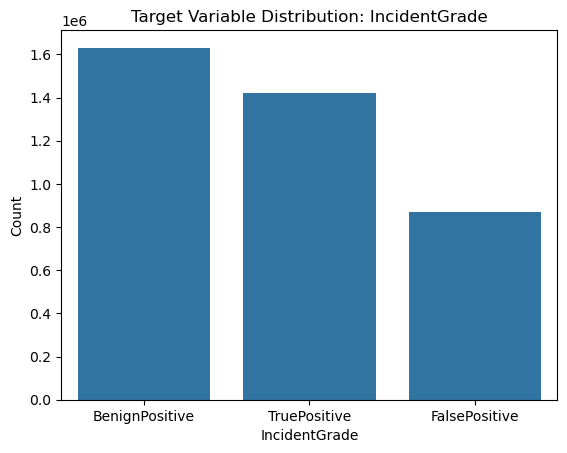

In [76]:
sns.countplot(data=test_data, x='IncidentGrade', order=test_data['IncidentGrade'].value_counts().index)
plt.title('Target Variable Distribution: IncidentGrade')
plt.xlabel('IncidentGrade')
plt.ylabel('Count')
plt.show()

# Feature Exploration and Engineering

In [77]:
test_data['Timestamp'] = pd.to_datetime(test_data['Timestamp'])
test_data['Year'] = test_data['Timestamp'].dt.year
test_data['Month'] = test_data['Timestamp'].dt.month
test_data['Day'] = test_data['Timestamp'].dt.day
test_data['Hour'] = test_data['Timestamp'].dt.hour

test_data.drop(columns='Timestamp',inplace=True)

In [78]:
test_data.columns

Index(['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'AlertTitle',
       'Category', 'IncidentGrade', 'EntityType', 'EvidenceRole', 'DeviceId',
       'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn',
       'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId',
       'RegistryKey', 'RegistryValueName', 'RegistryValueData',
       'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 'FileName',
       'FolderPath', 'ResourceIdName', 'OSFamily', 'OSVersion', 'CountryCode',
       'State', 'City', 'Year', 'Month', 'Day', 'Hour'],
      dtype='object')

# Exploratory Data Analysis (EDA) - Visualizing Distributions

In [79]:
test_data1 =test_data.copy()

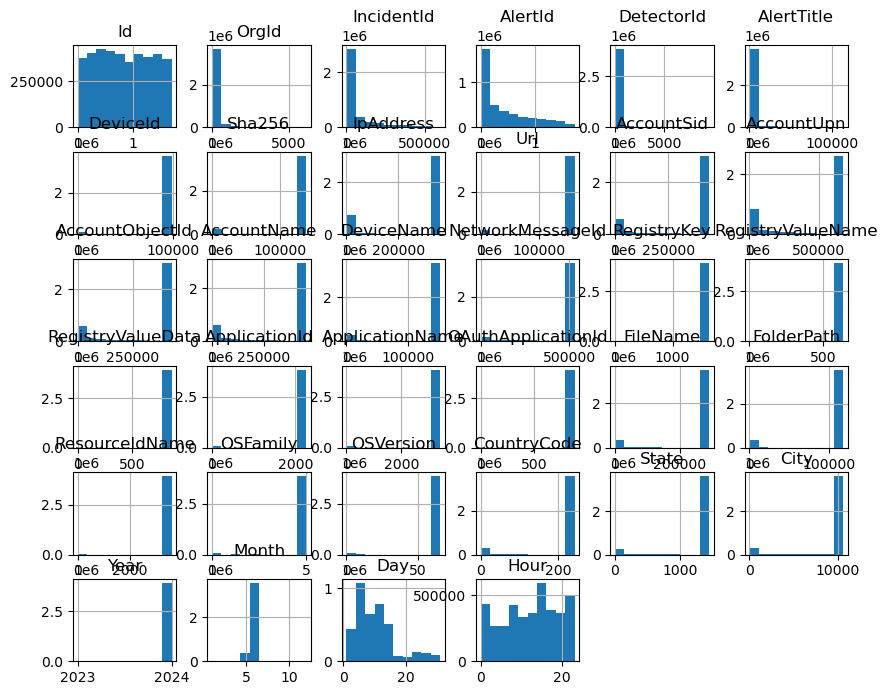

In [80]:
test_data.hist(figsize=(10,8))
plt.show()

In [81]:
# List of numeric columns in DataFrame
numeric_columns = test_data.select_dtypes(include=['int8','int16', 'int32', 'int64', 'float64'])


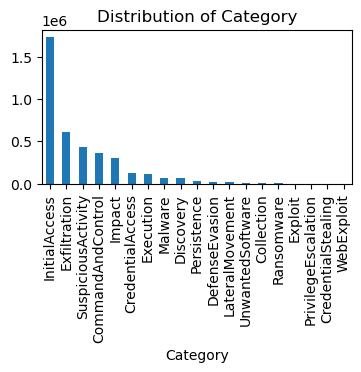

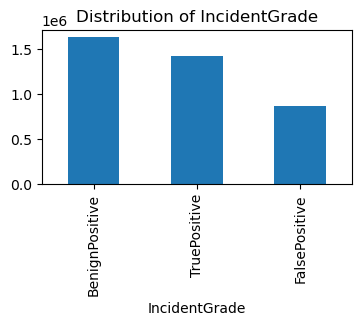

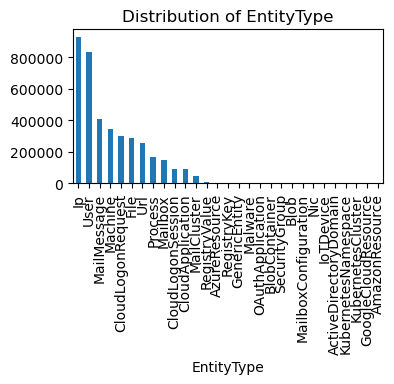

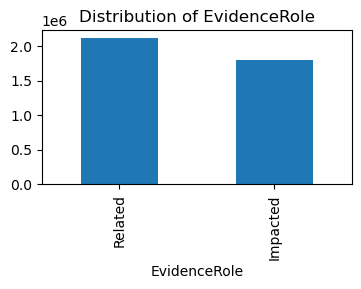

In [82]:
# Bar plot for categorical data
# List of categorical columns in DataFrame
categorical_columns = test_data.select_dtypes(include=['object','category'])

for col in categorical_columns:
    plt.figure(figsize=(4, 2))
    test_data[col].value_counts().plot(kind='bar')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.show()

# Visualizing the Data to Identify Outliers

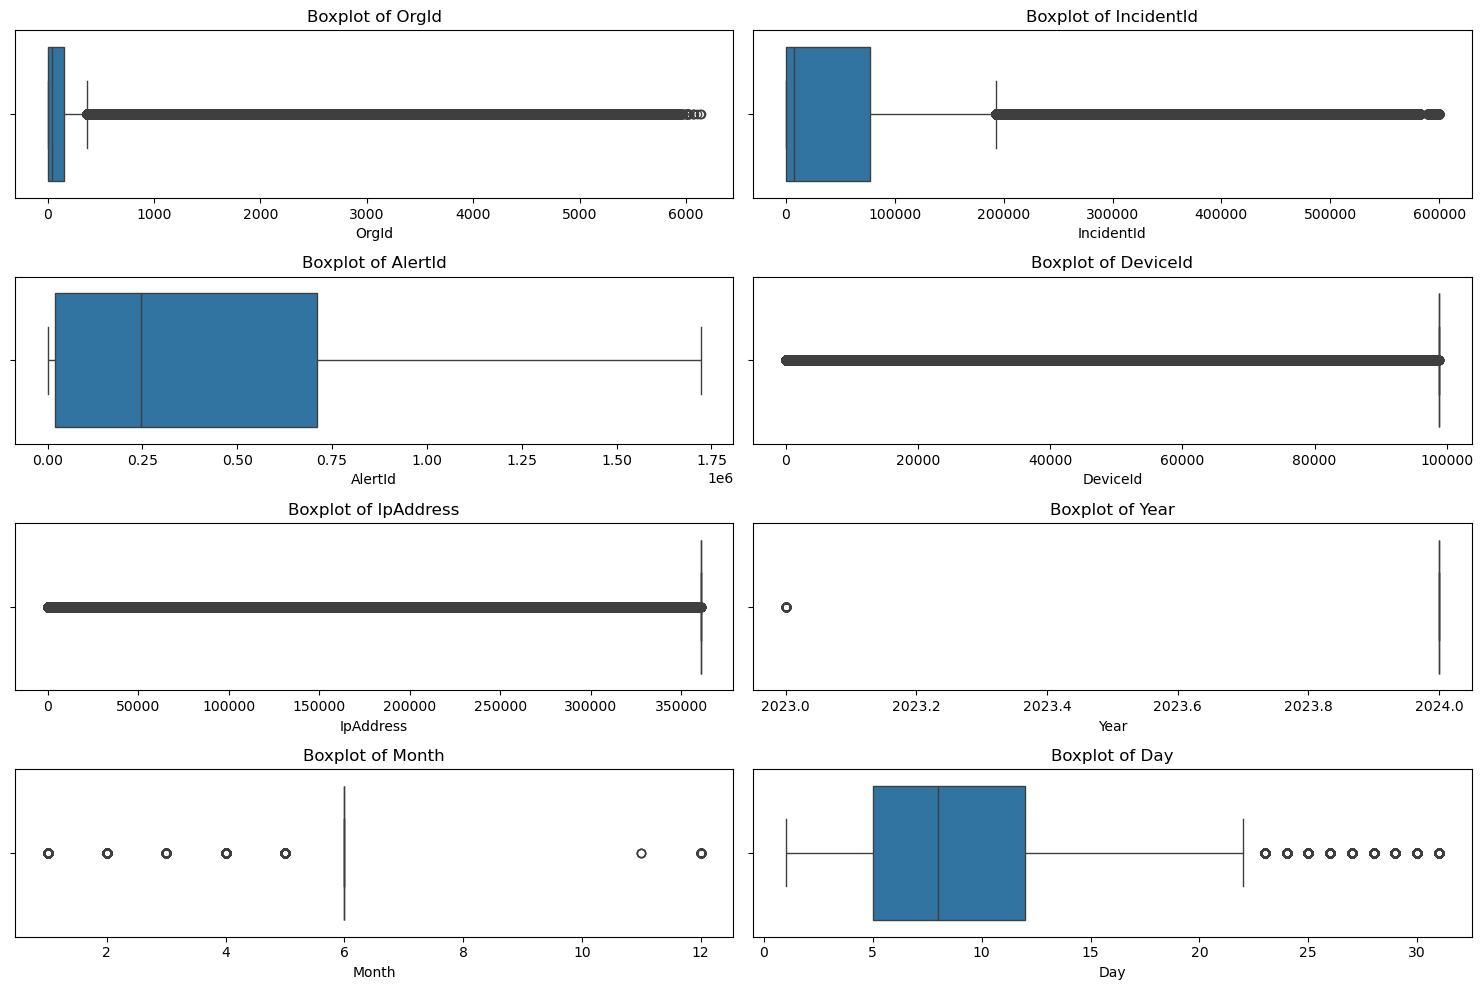

In [83]:
# Ploting box plots for numerical columns
numeric_cols = ['OrgId', 'IncidentId', 'AlertId', 'DeviceId', 'IpAddress', 'Year', 'Month', 'Day']
plt.figure(figsize=(15, 10))
num_plots = len(numeric_cols)
rows = (num_plots + 1) // 2

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(rows, 2, i)
    sns.boxplot(x=test_data[col])
    plt.title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

# Correlation Analysis

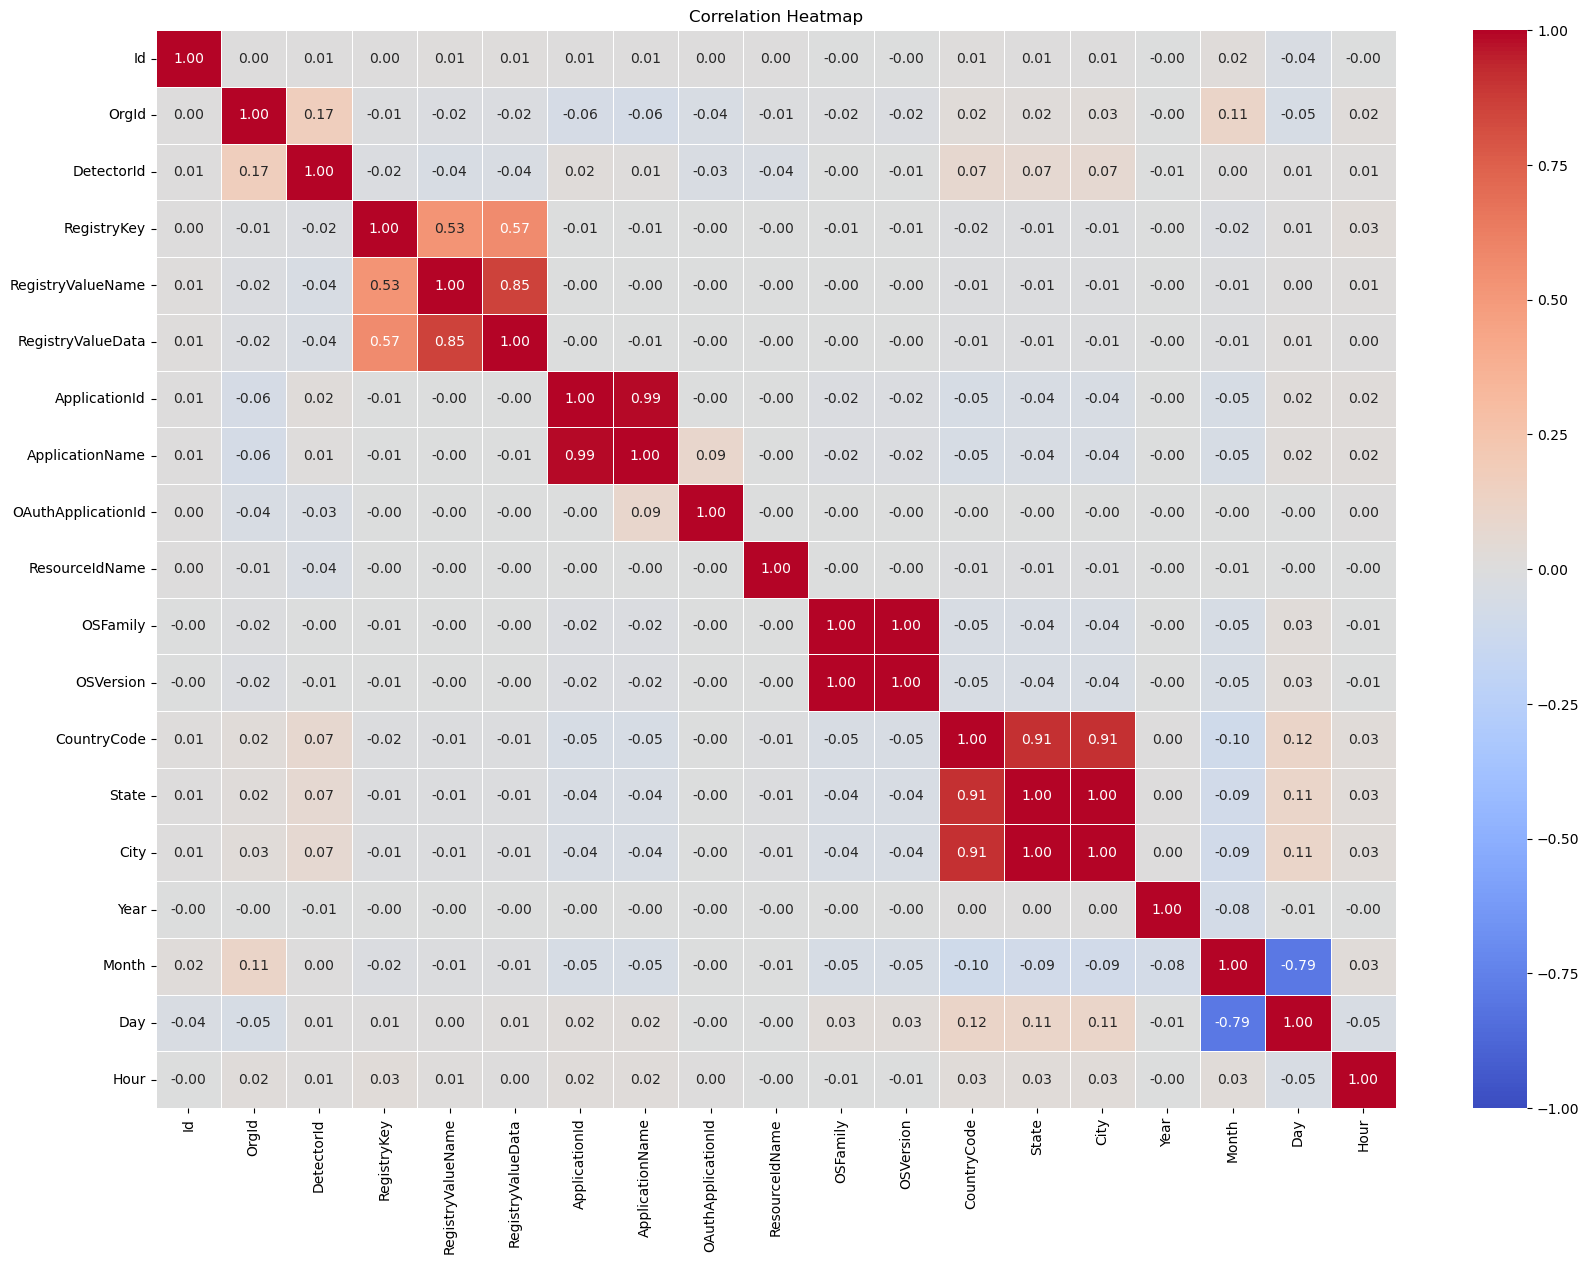

In [84]:
# heatmap visualization
plt.figure(figsize=(20, 14))
sns.heatmap(numeric_columns.corr(), annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

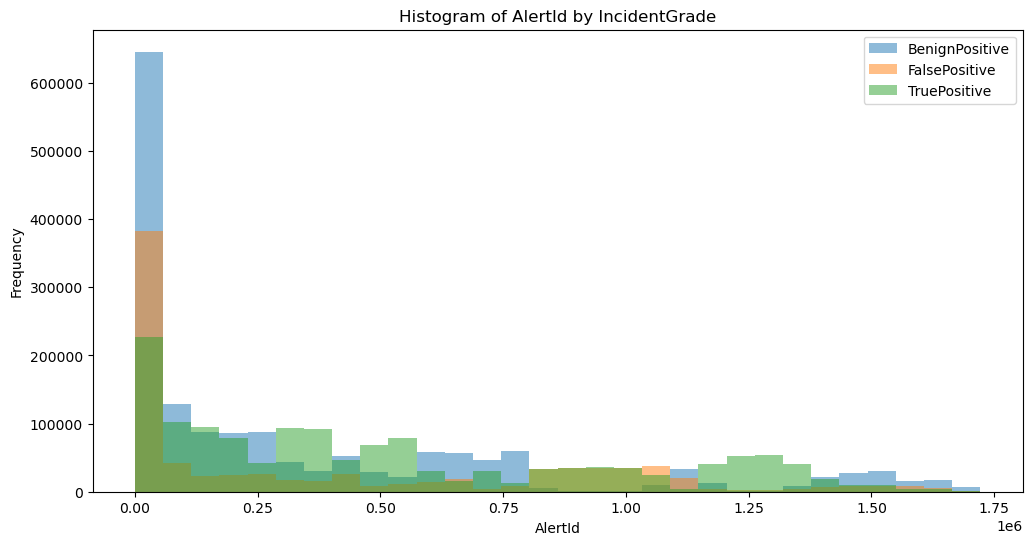

In [85]:
plt.figure(figsize=(12, 6))
for grade in test_data['IncidentGrade'].unique():
    subset = test_data[test_data['IncidentGrade'] == grade]
    plt.hist(subset['AlertId'], bins=30, alpha=0.5, label=grade)

plt.xlabel('AlertId')
plt.ylabel('Frequency')
plt.title('Histogram of AlertId by IncidentGrade')
plt.legend()
plt.show()

# Feature Importance via Random Forest

In [86]:
print(test_data.columns)
len(test_data.columns)

Index(['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'AlertTitle',
       'Category', 'IncidentGrade', 'EntityType', 'EvidenceRole', 'DeviceId',
       'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn',
       'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId',
       'RegistryKey', 'RegistryValueName', 'RegistryValueData',
       'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 'FileName',
       'FolderPath', 'ResourceIdName', 'OSFamily', 'OSVersion', 'CountryCode',
       'State', 'City', 'Year', 'Month', 'Day', 'Hour'],
      dtype='object')


38

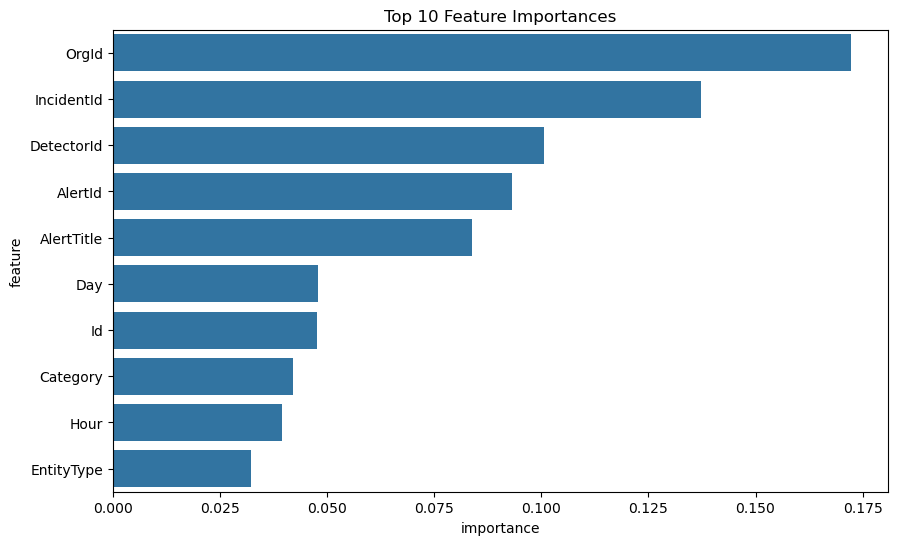

In [87]:
test_sample = test_data.sample(frac=0.001, random_state=42)
X = train_sample.drop(id_columns + ['IncidentGrade'], axis=1, errors='ignore')
y = train_sample['IncidentGrade']

non_numeric_cols = X.select_dtypes(exclude=['number']).columns
le = LabelEncoder()
for col in non_numeric_cols:
    X[col] = le.fit_transform(X[col].astype(str))

# Random Forest model
rf = RandomForestClassifier()
rf.fit(X, y)
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_})
feature_importances = feature_importances.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances.head(10))
plt.title('Top 10 Feature Importances')
plt.show()

In [88]:
# These features have minimal importance or are unlikely to impact your classification outcome
columns_to_drop = [
    'Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'DetectorId','Sha256', 'IpAddress', 
    'AccountSid', 'AccountUpn', 'AccountObjectId', 'DeviceId', 'NetworkMessageId',
    'RegistryKey', 'RegistryValueName', 'RegistryValueData', 'ApplicationId', 'ApplicationName',
    'OAuthApplicationId', 'FileName', 'FolderPath', 'ResourceIdName', 'OSVersion'
]
test_data.drop(columns=columns_to_drop, inplace=True)

In [89]:
test_data.shape

(3922695, 16)

# Handling Outliers

In [90]:
def handle_outliers(df, iqr_multiplier=3.0):
    numeric_features = df.select_dtypes(include=['int8','int16', 'int32', 'int64', 'float64'])
    for col in numeric_features.columns:
        # IQR method
        Q1 = numeric_features[col].quantile(0.25)
        Q3 = numeric_features[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - iqr_multiplier * IQR
        upper_bound = Q3 + iqr_multiplier * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
        
        # Quantile Capping
        q_low = df[col].quantile(0.01)
        q_high = df[col].quantile(0.99)
        df[col] = df[col].clip(lower=q_low, upper=q_high)
        
    return df

In [91]:
test_data.shape

(3922695, 16)

# Encoding Categorical Variables

## Label Encoding for Ordinal Variables \ One-hot encoding for nominal columns

In [92]:
categorical_columns = ['AlertTitle', 'Category', 'EntityType', 'EvidenceRole',
       'Url', 'AccountName', 'DeviceName', 'OSFamily', 'CountryCode', 'State', 'City', 'Year',
       'Month', 'Day', 'Hour']

In [93]:
# List of columns to process
columns_to_group = ['AlertTitle', 'Url', 'AccountName', 'DeviceName', 'CountryCode', 'State', 'City']

# Looping through each column and grouping the less frequent values into "Others"
for column in columns_to_group:
    category_counts = test_data[column].value_counts()
    top_categories = category_counts.nlargest(8).index
    test_data[column] = test_data[column].where(test_data[column].isin(top_categories), 'Others')

# Now verifing the changes
test_data

,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,Url,AccountName,DeviceName,OSFamily,CountryCode,State,City,Year,Month,Day,Hour
0,Others,LateralMovement,BenignPositive,User,Impacted,160396,Others,153085,5,242,1445,10630,2024,6,4,22
1,2,CommandAndControl,BenignPositive,Machine,Impacted,160396,453297,Others,0,242,1445,10630,2024,6,3,12
2,Others,LateralMovement,BenignPositive,Process,Related,160396,453297,153085,5,242,1445,10630,2024,6,8,3
3,0,InitialAccess,FalsePositive,CloudLogonSession,Related,160396,453297,153085,5,242,1445,10630,2024,6,12,12
4,Others,Discovery,BenignPositive,User,Impacted,160396,Others,153085,5,242,1445,10630,2024,6,6,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4147985,Others,Malware,BenignPositive,Machine,Impacted,160396,453297,4,0,242,1445,10630,2024,6,3,20
4147987,Others,InitialAccess,BenignPositive,User,Impacted,160396,Others,153085,5,242,1445,10630,2024,6,4,3
4147988,Others,InitialAccess,BenignPositive,User,Impacted,160396,Others,153085,5,242,1445,10630,2024,6,4,19
4147989,Others,CommandAndControl,FalsePositive,Ip,Related,160396,453297,153085,5,242,1445,10630,2024,6,15,0


In [94]:
# Label Encoding for IncidentGrade (Target Variable)
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
test_data['IncidentGrade'] = le.fit_transform(test_data['IncidentGrade'])

# One-Hot Encoding for nominal features
test_data = pd.get_dummies(test_data, columns=categorical_columns, drop_first=True)

In [95]:
test_data.shape

(3922695, 169)

# Scaling/Normalization \ StandardScaler


In [96]:
from sklearn.preprocessing import StandardScaler

# Define the ID columns to exclude from scaling
id_columns = ['ID']  # Replace with your actual ID column names if needed

# Select numeric columns (int and float) from test_data and exclude the ID columns
numeric_features = test_data.select_dtypes(include=['int8', 'int16', 'int32', 'int64', 'float64']).drop(columns=id_columns, errors='ignore')

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on train_data (to avoid data leakage) and transform test_data
test_data[numeric_features.columns] = scaler.fit_transform(numeric_features)

# Confirm scaling (optional)
print(test_data.head())  # Inspect the first few rows of the scaled test data


   IncidentGrade  AlertTitle_1  AlertTitle_2  AlertTitle_3  AlertTitle_4  \
0      -1.075194         False         False         False         False   
1      -1.075194         False          True         False         False   
2      -1.075194         False         False         False         False   
3       0.060231         False         False         False         False   
4      -1.075194         False         False         False         False   

   AlertTitle_5  AlertTitle_6  AlertTitle_7  AlertTitle_Others  \
0         False         False         False               True   
1         False         False         False              False   
2         False         False         False               True   
3         False         False         False              False   
4         False         False         False               True   

   Category_CommandAndControl  ...  Hour_14  Hour_15  Hour_16  Hour_17  \
0                       False  ...    False    False    False    False  

# Saving the Cleaned Test Data set as CSV for further processing

In [97]:
print(train_data.shape)
print(test_data.shape)

(8970539, 175)
(3922695, 169)


In [98]:
test_data.shape

(3922695, 169)

In [107]:
train_data, test_data = train_data.align(test_data, join='left', axis=1)
test_data.fillna(0, inplace=True)

In [108]:
test_data.shape

(3922695, 175)

In [109]:
test_data = test_data.reset_index(drop=True)

In [110]:
# Saveing the data using Joblib
joblib.dump(test_data, 'encoded_test_data.joblib')

['encoded_test_data.joblib']

In [112]:
# Loading the data using Joblib
test_data = joblib.load('encoded_test_data.joblib')

In [113]:
test_data.head()

,IncidentGrade,AlertTitle_1,AlertTitle_2,AlertTitle_3,AlertTitle_4,AlertTitle_5,AlertTitle_6,AlertTitle_7,AlertTitle_Others,Category_CommandAndControl,...,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23
0,-1.075194,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False
1,-1.075194,False,True,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
2,-1.075194,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
3,0.060231,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,-1.075194,False,False,False,False,False,False,False,True,False,...,False,False,False,True,False,False,False,False,False,False


In [115]:
test_data.to_csv("final_test_data.csv",index=False)

In [116]:
print(test_data.memory_usage(deep=True).sum() / (1024 ** 2), "MB")

1032.508804321289 MB
